In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import glob
import os

# === 1. Setup ===
# Parent directory containing all SGNex_* folders
data_dir = "../Task 2"  # e.g. "data/"

# Find all processed_data.csv files inside subfolders
file_paths = glob.glob(os.path.join(data_dir, "SGNex_*", "processed_data.csv"))

# Load all CSVs into a dictionary
datasets = {}
for path in file_paths:
    # Extract the folder name (e.g. SGNex_HepG2_directRNA_replicate6_run1)
    folder_name = os.path.basename(os.path.dirname(path))
    df = pd.read_csv(path, sep=",", encoding='utf-8-sig')
    # Clean column names: remove spaces, lowercase, and strip invisible chars
    df.columns = df.columns.str.strip().str.lower()
    datasets[folder_name] = df
    print(f"Loaded {folder_name}: {df.shape[0]} rows, {df.shape[1]} columns")

print(f"\nTotal datasets loaded: {len(datasets)}")

Loaded SGNex_K562_directRNA_replicate5_run1:: 9673164 rows, 12 columns
Loaded SGNex_MCF7_directRNA_replicate3_run1:: 12740906 rows, 12 columns
Loaded SGNex_A549_directRNA_replicate5_run1:: 8160696 rows, 12 columns
Loaded SGNex_Hct116_directRNA_replicate3_run4:: 15133352 rows, 12 columns
Loaded SGNex_Hct116_directRNA_replicate4_run3:: 25873301 rows, 12 columns
Loaded SGNex_MCF7_directRNA_replicate4_run1:: 15671886 rows, 12 columns
Loaded SGNex_K562_directRNA_replicate6_run1:: 11781235 rows, 12 columns
Loaded SGNex_A549_directRNA_replicate6_run1:: 20215387 rows, 12 columns
Loaded SGNex_K562_directRNA_replicate4_run1:: 10389893 rows, 12 columns
Loaded SGNex_HepG2_directRNA_replicate6_run1:: 25882857 rows, 12 columns
Loaded SGNex_Hct116_directRNA_replicate3_run1:: 16823006 rows, 12 columns
Loaded SGNex_HepG2_directRNA_replicate5_run2:: 27928565 rows, 12 columns

Total datasets loaded: 12


In [2]:
quality_summary = []

for name, df in datasets.items():
    duplicate_count = df.duplicated(subset=["transcript_id", "transcript_position"]).sum()
    total_rows = df.shape[0]
    duplicate_ratio = duplicate_count / total_rows * 100
    
    quality_summary.append({
        "Dataset": name,
        "Total Rows": total_rows,
        "Duplicate Pairs": duplicate_count,
        "Duplicate (%)": round(duplicate_ratio, 3)
    })

quality_df = pd.DataFrame(quality_summary)
print(quality_df)

                                    Dataset  Total Rows  Duplicate Pairs  \
0     SGNex_K562_directRNA_replicate5_run1:     9673164          8620563   
1     SGNex_MCF7_directRNA_replicate3_run1:    12740906         11488289   
2     SGNex_A549_directRNA_replicate5_run1:     8160696          7151763   
3   SGNex_Hct116_directRNA_replicate3_run4:    15133352         13830838   
4   SGNex_Hct116_directRNA_replicate4_run3:    25873301         24273554   
5     SGNex_MCF7_directRNA_replicate4_run1:    15671886         14225864   
6     SGNex_K562_directRNA_replicate6_run1:    11781235         10782135   
7     SGNex_A549_directRNA_replicate6_run1:    20215387         18714808   
8     SGNex_K562_directRNA_replicate4_run1:    10389893          9285449   
9    SGNex_HepG2_directRNA_replicate6_run1:    25882857         24317967   
10  SGNex_Hct116_directRNA_replicate3_run1:    16823006         15431776   
11   SGNex_HepG2_directRNA_replicate5_run2:    27928565         26347678   

    Duplica

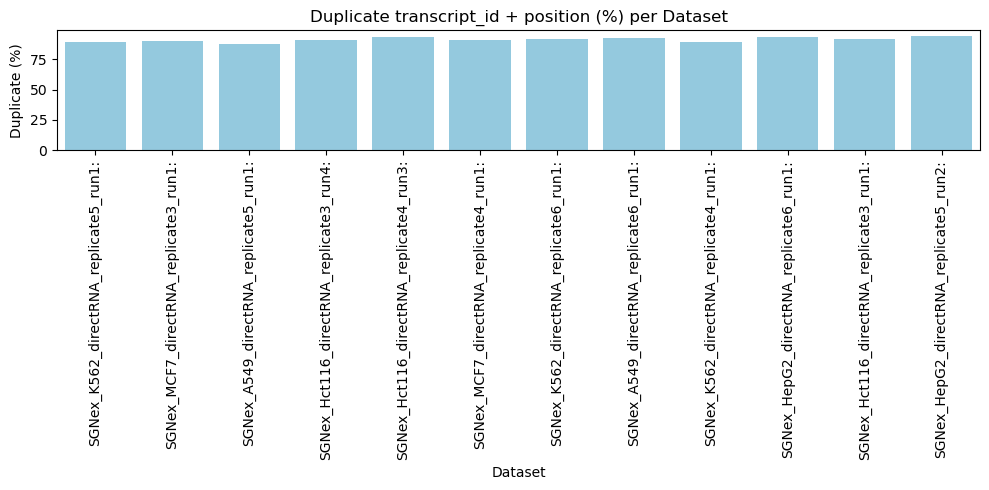

In [4]:
plt.figure(figsize=(10,5))
sns.barplot(x="Dataset", y="Duplicate (%)", data=quality_df, color="skyblue")
plt.title("Duplicate transcript_id + position (%) per Dataset")
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()


In [5]:
aggregated_datasets = {}
agg_summary = []

for name, df in datasets.items():
    # Exclude non-numeric columns from mean aggregation
    numeric_cols = df.select_dtypes(include='number').columns
    group_cols = ["transcript_id", "transcript_position"]

    # Aggregate duplicates by taking the mean of numeric columns
    df_agg = df.groupby(group_cols, as_index=False)[numeric_cols].mean()

    aggregated_datasets[name] = df_agg

    # Record summary statistics
    before = df.shape[0]
    after = df_agg.shape[0]
    reduction = before - after
    agg_summary.append({
        "Dataset": name,
        "Before Rows": before,
        "After Rows": after,
        "Duplicates Removed": reduction,
        "Reduction (%)": round(reduction / before * 100, 2)
    })

agg_df = pd.DataFrame(agg_summary)
print("\n=== Aggregation Summary ===")
print(agg_df)



=== Aggregation Summary ===
                                    Dataset  Before Rows  After Rows  \
0     SGNex_K562_directRNA_replicate5_run1:      9673164     1052601   
1     SGNex_MCF7_directRNA_replicate3_run1:     12740906     1252617   
2     SGNex_A549_directRNA_replicate5_run1:      8160696     1008933   
3   SGNex_Hct116_directRNA_replicate3_run4:     15133352     1302514   
4   SGNex_Hct116_directRNA_replicate4_run3:     25873301     1599747   
5     SGNex_MCF7_directRNA_replicate4_run1:     15671886     1446022   
6     SGNex_K562_directRNA_replicate6_run1:     11781235      999100   
7     SGNex_A549_directRNA_replicate6_run1:     20215387     1500579   
8     SGNex_K562_directRNA_replicate4_run1:     10389893     1104444   
9    SGNex_HepG2_directRNA_replicate6_run1:     25882857     1564890   
10  SGNex_Hct116_directRNA_replicate3_run1:     16823006     1391230   
11   SGNex_HepG2_directRNA_replicate5_run2:     27928565     1580887   

    Duplicates Removed  Reduction 

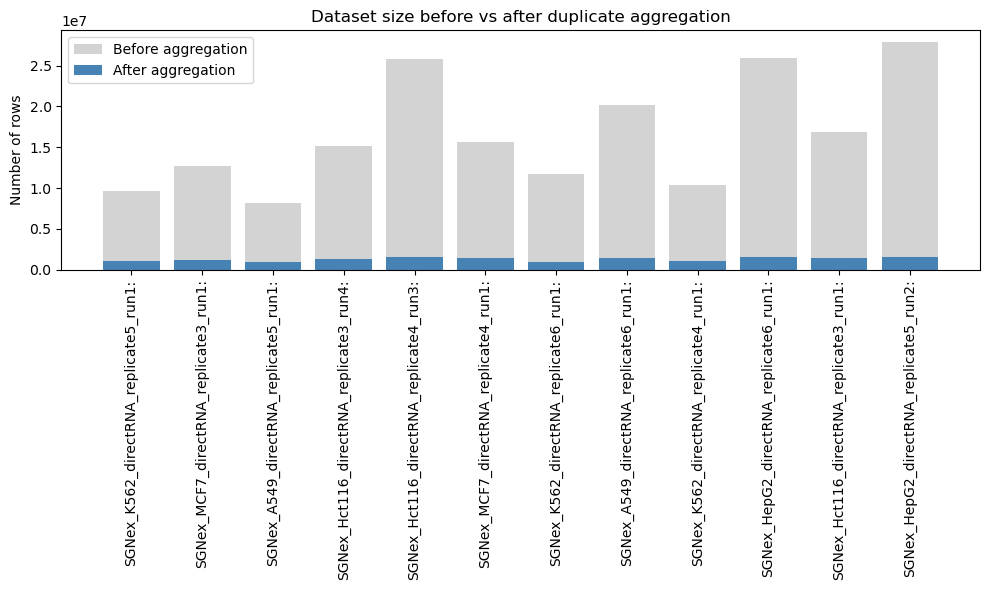

In [8]:
plt.figure(figsize=(10,6))
plt.bar(agg_df["Dataset"], agg_df["Before Rows"], color="lightgray", label="Before aggregation")
plt.bar(agg_df["Dataset"], agg_df["After Rows"], color="steelblue", label="After aggregation")
plt.xticks(rotation=90)
plt.ylabel("Number of rows")
plt.title("Dataset size before vs after duplicate aggregation")
plt.legend()
plt.tight_layout()
plt.show()


In [17]:
feature_cols = [col for col in aggregated_datasets[list(aggregated_datasets.keys())[0]].columns if col.startswith("feature_")]

feature_stats = {}

for name, df in aggregated_datasets.items():
    # Compute mean and variance per transcript
    transcript_stats = df.groupby("transcript_id")[feature_cols].agg(['mean', 'var']).reset_index()
    
    # Flatten the multi-level columns
    transcript_stats.columns = ['_'.join(col).rstrip('_') for col in transcript_stats.columns.values]
    
    feature_stats[name] = transcript_stats

    print(f"{name}: computed {len(transcript_stats)} transcripts")

SGNex_K562_directRNA_replicate5_run1:: computed 37586 transcripts
SGNex_MCF7_directRNA_replicate3_run1:: computed 46297 transcripts
SGNex_A549_directRNA_replicate5_run1:: computed 30758 transcripts
SGNex_Hct116_directRNA_replicate3_run4:: computed 39963 transcripts
SGNex_Hct116_directRNA_replicate4_run3:: computed 46015 transcripts
SGNex_MCF7_directRNA_replicate4_run1:: computed 43486 transcripts
SGNex_K562_directRNA_replicate6_run1:: computed 36412 transcripts
SGNex_A549_directRNA_replicate6_run1:: computed 43161 transcripts
SGNex_K562_directRNA_replicate4_run1:: computed 38801 transcripts
SGNex_HepG2_directRNA_replicate6_run1:: computed 42529 transcripts
SGNex_Hct116_directRNA_replicate3_run1:: computed 39378 transcripts
SGNex_HepG2_directRNA_replicate5_run2:: computed 44803 transcripts


In [18]:
# Collect all feature mean/var pairs into a single long dataframe
all_scatter_data = []

for name, stats in feature_stats.items():
    # Reshape the data from wide (feature_1_mean, feature_1_var, ...) to long
    for feature in [col.replace('_mean','') for col in stats.columns if col.endswith('_mean')]:
        df_long = stats[[f"{feature}_mean", f"{feature}_var"]].copy()
        df_long.columns = ["mean", "var"]
        df_long["feature"] = feature
        df_long["dataset"] = name
        all_scatter_data.append(df_long)

all_scatter_data = pd.concat(all_scatter_data, ignore_index=True)


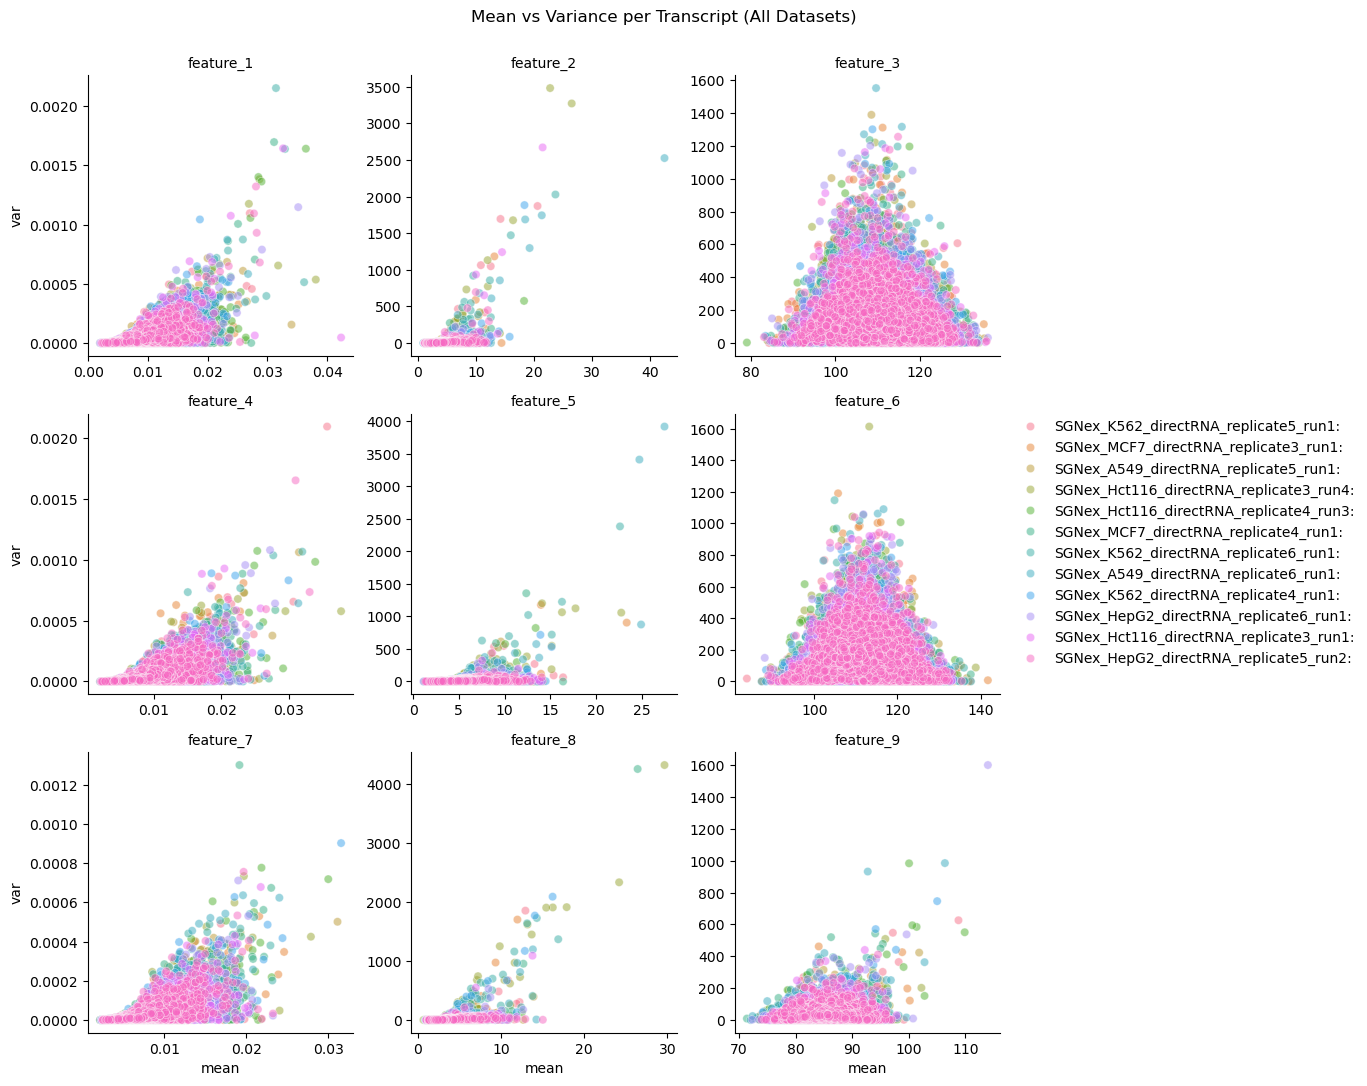

In [15]:
g = sns.FacetGrid(
    all_scatter_data,
    col="feature",
    col_wrap=3,
    height=3.5,
    sharex=False,
    sharey=False
)
g.map_dataframe(sns.scatterplot, x="mean", y="var", hue="dataset", alpha=0.5)
g.add_legend()
g.set_titles(col_template="{col_name}")
g.fig.suptitle("Mean vs Variance per Transcript (All Datasets)", y=1.03)
plt.show()


In [6]:
# Folder containing prediction CSVs
base_path = "../model_predictions"

# Load all CSVs starting with "SGNex_"
prediction_datasets = {}
for file in os.listdir(base_path):
    if file.startswith("SGNex_") and file.endswith(".csv"):
        file_path = os.path.join(base_path, file)
        df = pd.read_csv(file_path)
        df.columns = df.columns.str.strip().str.lower()  # normalize column names
        prediction_datasets[file] = df
        print(f"Loaded {file}: {len(df)} rows, {df['transcript_id'].nunique()} transcripts")

Loaded SGNex_A549_directRNA_replicate5_run1_results.csv: 1008933 rows, 30758 transcripts
Loaded SGNex_K562_directRNA_replicate6_run1_results.csv: 999100 rows, 36412 transcripts
Loaded SGNex_Hct116_directRNA_replicate3_run1_results.csv: 1391230 rows, 39378 transcripts
Loaded SGNex_A549_directRNA_replicate6_run1_results.csv: 1500579 rows, 43161 transcripts


In [8]:
summary_stats = []

for name, df in prediction_datasets.items():
    per_transcript = df.groupby("transcript_id")["score"].agg(["mean", "var", "count"]).reset_index()
    summary_stats.append({
        "Dataset": name,
        "Num transcripts": per_transcript.shape[0],
        "Avg mean score": per_transcript["mean"].mean(),
        "Avg variance": per_transcript["var"].mean(),
        "Avg number of positions": per_transcript["count"].mean()
    })

summary_df = pd.DataFrame(summary_stats)
print(summary_df)

                                             Dataset  Num transcripts  \
0   SGNex_A549_directRNA_replicate5_run1_results.csv            30758   
1   SGNex_K562_directRNA_replicate6_run1_results.csv            36412   
2  SGNex_Hct116_directRNA_replicate3_run1_results...            39378   
3   SGNex_A549_directRNA_replicate6_run1_results.csv            43161   

   Avg mean score  Avg variance  Avg number of positions  
0        0.213240      0.074255                32.802295  
1        0.222625      0.076988                27.438756  
2        0.214529      0.073851                35.330134  
3        0.226956      0.076996                34.767012  


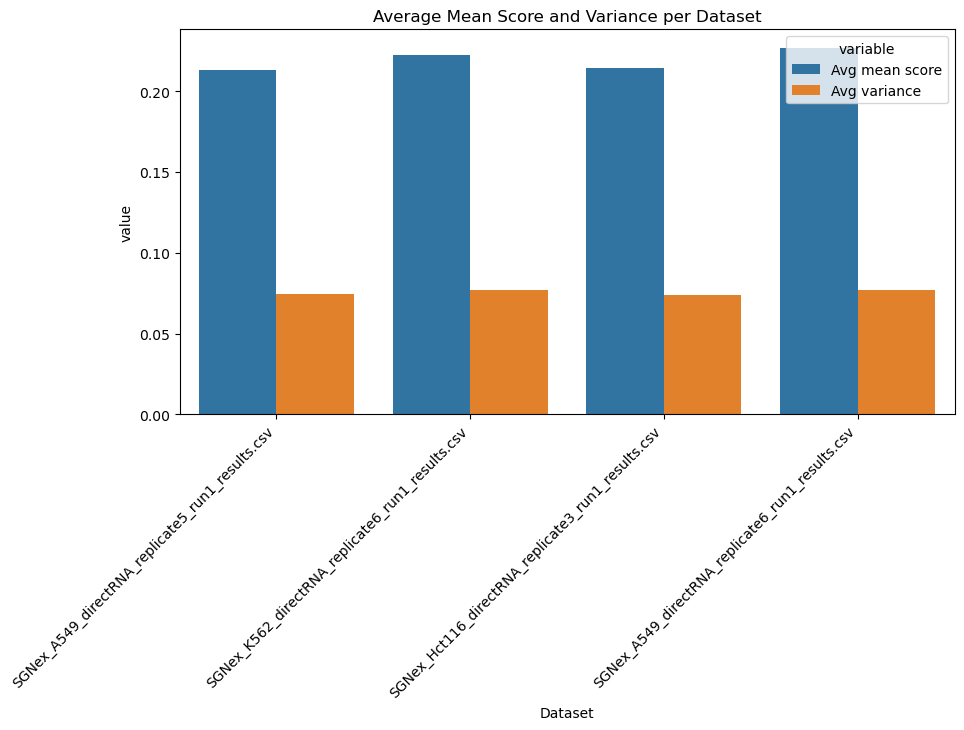

In [9]:
plt.figure(figsize=(10, 5))
sns.barplot(data=summary_df.melt(id_vars="Dataset", value_vars=["Avg mean score", "Avg variance"]),
            x="Dataset", y="value", hue="variable")
plt.title("Average Mean Score and Variance per Dataset")
plt.xticks(rotation=45, ha="right")
plt.show()


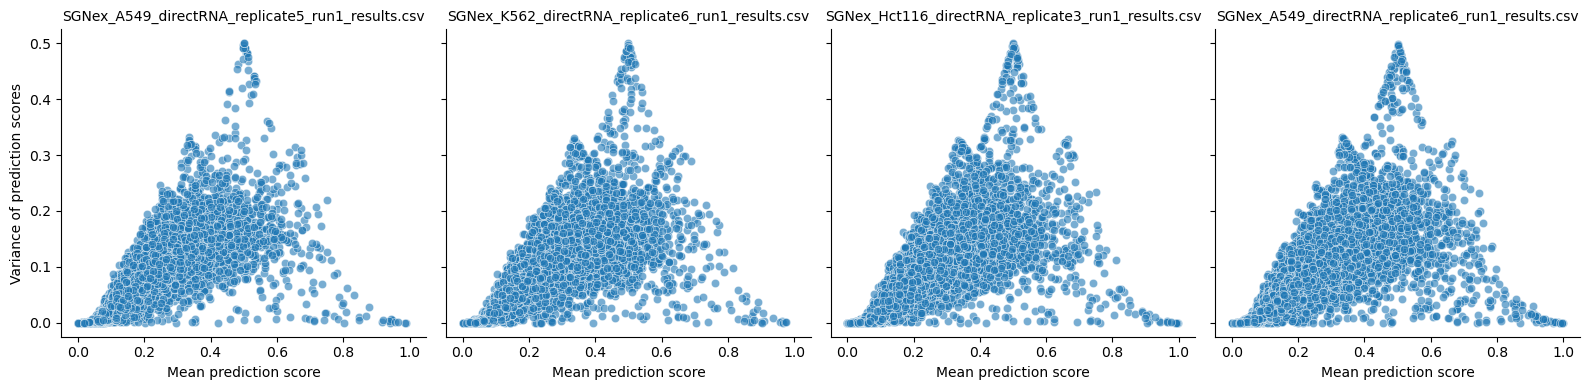

In [17]:
# Combine all datasets into one dataframe
combined = []
for name, df in prediction_datasets.items():
    per_transcript = df.groupby("transcript_id")["score"].agg(["mean", "var"]).reset_index()
    per_transcript["dataset"] = name
    combined.append(per_transcript)

combined_df = pd.concat(combined, ignore_index=True)

# FacetGrid scatterplot: mean vs variance per transcript, faceted by dataset
g = sns.FacetGrid(combined_df, col="dataset", col_wrap=4, sharex=True, sharey=True, height=4)
g.map_dataframe(sns.scatterplot, x="mean", y="var", alpha=0.6)
g.set_axis_labels("Mean prediction score", "Variance of prediction scores")
g.set_titles("{col_name}")
plt.tight_layout()
plt.show()

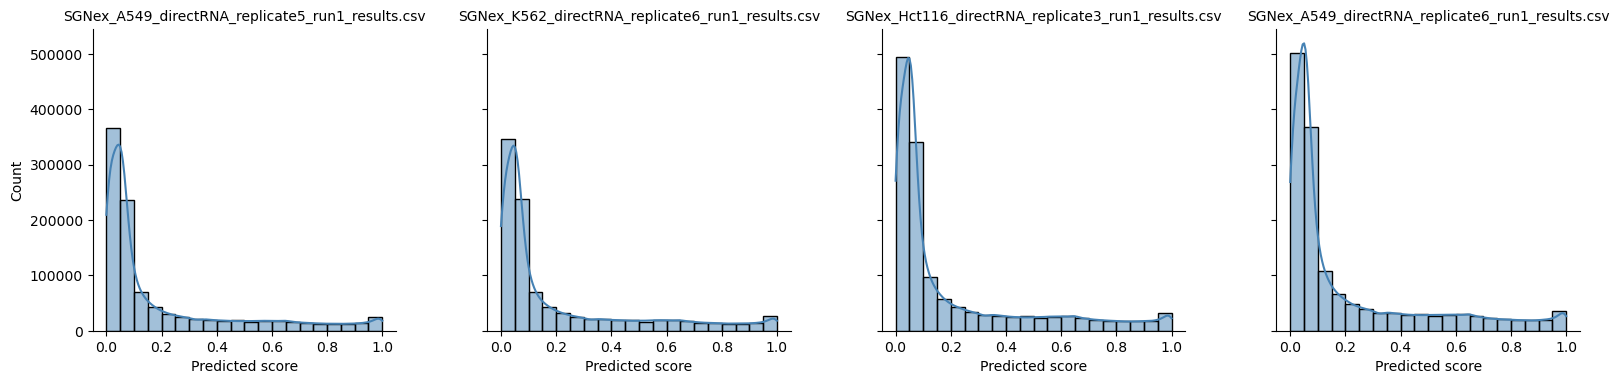

In [28]:
combined = []
for name, df in prediction_datasets.items():
    df["dataset"] = name
    combined.append(df)
combined_df = pd.concat(combined, ignore_index=True)

# Create FacetGrid
g = sns.FacetGrid(combined_df, col="dataset", col_wrap=4, sharex=True, sharey=True, height=4)
g.map(sns.histplot, "score", bins=20, color="steelblue", kde=True)

# Adjust titles and axis labels
g.set_titles("{col_name}", size=10)  # smaller font size for titles
g.set_axis_labels("Predicted score", "Count")

# Adjust spacing
g.fig.subplots_adjust(top=0.9, hspace=0.4, wspace=0.3)  # add vertical/horizontal spacing

plt.show()

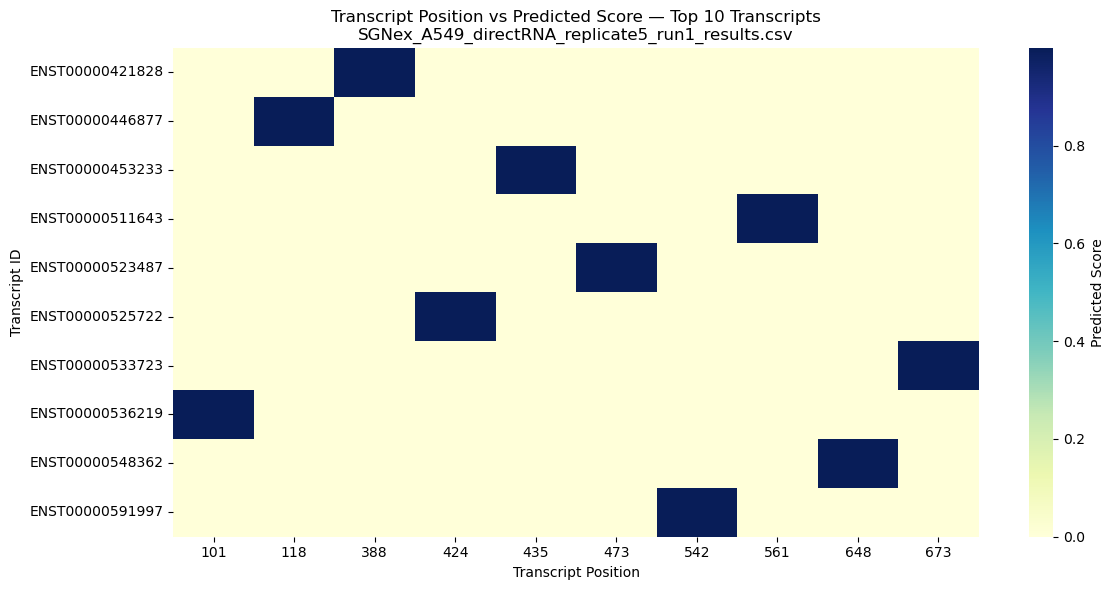

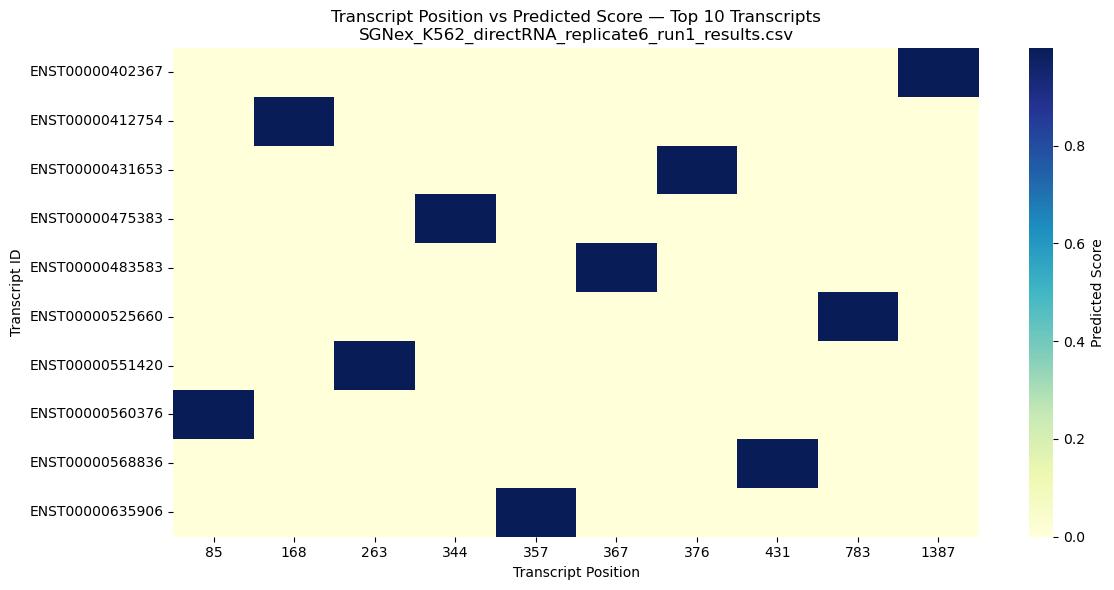

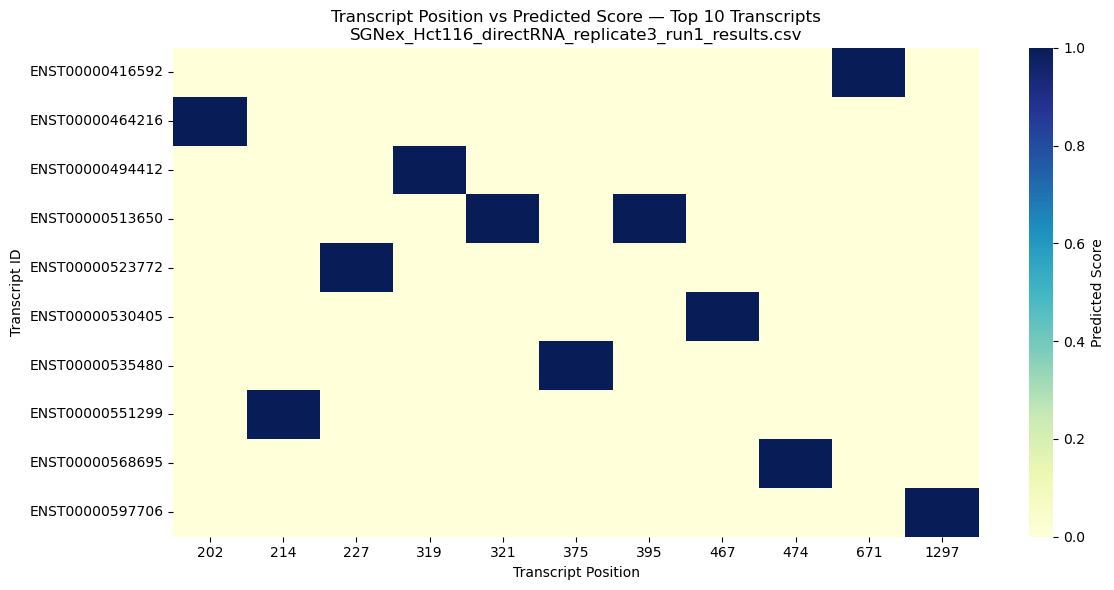

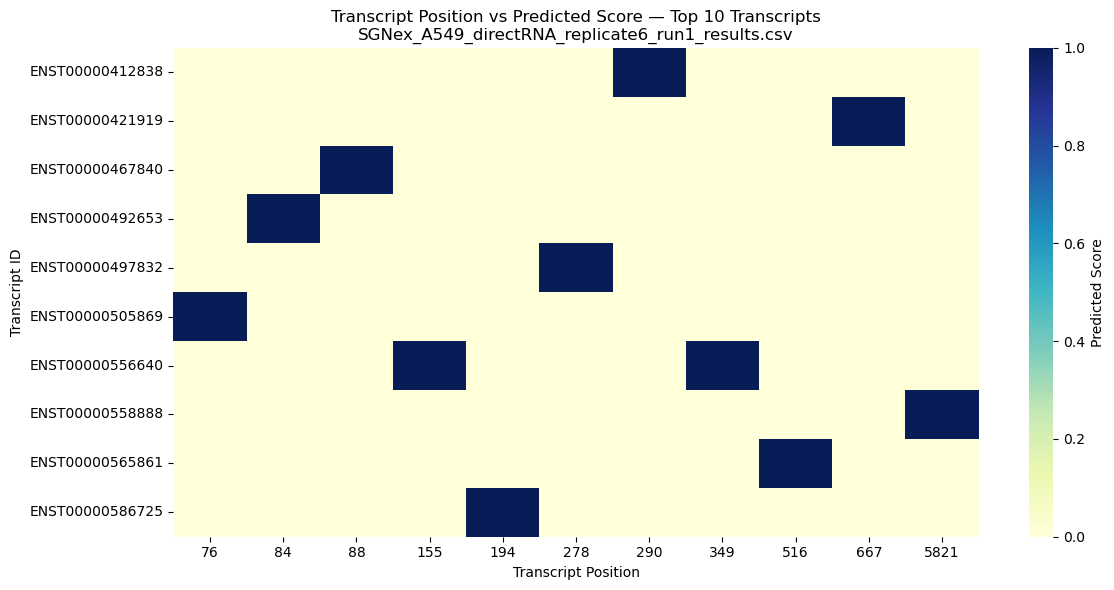

In [26]:
top_n = 10  # number of top transcripts per dataset

for name, df in prediction_datasets.items():
    # Compute mean score per transcript
    transcript_mean = df.groupby("transcript_id")["score"].mean().reset_index()
    top_transcripts = transcript_mean.nlargest(top_n, "score")["transcript_id"].tolist()
    
    # Filter original dataframe for top transcripts
    top_df = df[df["transcript_id"].isin(top_transcripts)].copy()
    
    # Pivot for heatmap: transcript_id on y-axis, transcript_position on x-axis
    heatmap_df = top_df.pivot_table(index="transcript_id",
                                    columns="transcript_position",
                                    values="score",
                                    aggfunc="mean").fillna(0)
    
    # Plot heatmap
    plt.figure(figsize=(12, 6))
    sns.heatmap(heatmap_df, cmap="YlGnBu", cbar_kws={'label': 'Predicted Score'})
    plt.title(f"Transcript Position vs Predicted Score — Top {top_n} Transcripts\n{name}")
    plt.xlabel("Transcript Position")
    plt.ylabel("Transcript ID")
    plt.tight_layout()
    plt.show()